# Sensor Data Classification

Author : Phanidhar Akula

## 1. Introduction

This project aims to classify human activities based on sensor data (accelerometer, gyroscope, magnetometer, and pressure) collected from multiple users.

1. **Dataset:** Uses `DataSet2`, which contains data of 15 users (13 - 27) performing 15 activities (1 - 15) by each user.
2. **Feature Extraction:** Extracting features like mean, median, standard deviation, min, max from each axis.
3. **Plotting:** Plot the sensor data for each activity
4. **Classifiers:** Using multiple classifiers like LogisticRegression, NaiveBayes, DecisionTree, RandomForest.
5. **Ensemble:** An ensemble (`VotingClassifier`) of the best models.
6. **Single Activity Prediction:** Prediction on a chosen single user/activity pair.

### Import necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

## 2. Data Processing

- Dataset Structure

  ```
  ./DataSet2/
      User13/
          Activity1/
              Accelerometer.csv
              Gyroscope.csv
              Magnetometer.csv
              Pressure.csv
          Activity2/
              ...
      User14/
          Activity1/
          ...
      ...
  ```

- Dataset contains data of 15 users (13 - 27) performing 15 activities (1 - 15) by each user.
- Sensors have columns like `time (-13:00)`, `(x-axis (g))`, etc.
- The dataset has some missing files, so the project includes code to handle missing files gracefully.

Link to the updated dataset : https://tinyurl.com/updated-dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path to the dataset from the drive

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/DataSet2"

Get activity count based on user_id.

In [ ]:
def get_activity_count(user_id):
    if 13 <= user_id <= 23:
        return 15
    elif user_id in [24, 26, 27]:
        return 12
    elif user_id == 25:
        return 13
    else:
        return 0

Load and process raw sensor data.

In [ ]:
def load_sensor_data(file_path):
    if not os.path.exists(file_path):
        print(f"[WARNING] Missing file: {file_path}")
        return pd.DataFrame()
    try:
        df = pd.read_csv(file_path, header=0)
        df.dropna(how="all", inplace=True)
        if "time (-13:00)" in df.columns:
            df.sort_values("time (-13:00)", inplace=True, ignore_index=True)
        return df
    except Exception as e:
        print(f"[ERROR] Could not process {file_path}: {e}")
        return pd.DataFrame()

## 3. Feature Extraction

1. **Windowing:** Segment each sensor CSV into fixed-size windows (e.g., 100 rows).
2. **Feature Computation**: For each window, compute **mean**, **median**, **std**, **min**, **max** for each axis.
3. Combine features from each sensor into one row, adding `user_id` and `activity_id` columns to label them.

If no existing CSV with features is found (named by default `DataSet2_AllSensors_Featured.csv`), the pipeline auto-generates it.

In [ ]:
def window_data(df, window_size=100):
    windows = []
    n = len(df)
    for start in range(0, n, window_size):
        end = start + window_size
        if end <= n:
            windows.append(df.iloc[start:end])
    return windows

Extracts (mean, std, min, max, median) from each axis/column for the given sensor window and create one single feature CSV.

In [ ]:
def extract_features(sensor_name, window_df):
    feats = {}

    if sensor_name == "accelerometer":
        xcol, ycol, zcol = "x-axis (g)", "y-axis (g)", "z-axis (g)"
        if xcol in window_df.columns:
            feats["acc_x_mean"]   = window_df[xcol].mean()
            feats["acc_x_median"] = window_df[xcol].median()
            feats["acc_x_std"]    = window_df[xcol].std()
            feats["acc_x_min"]    = window_df[xcol].min()
            feats["acc_x_max"]    = window_df[xcol].max()
        if ycol in window_df.columns:
            feats["acc_y_mean"]   = window_df[ycol].mean()
            feats["acc_y_median"] = window_df[ycol].median()
            feats["acc_y_std"]    = window_df[ycol].std()
            feats["acc_y_min"]    = window_df[ycol].min()
            feats["acc_y_max"]    = window_df[ycol].max()
        if zcol in window_df.columns:
            feats["acc_z_mean"]   = window_df[zcol].mean()
            feats["acc_z_median"] = window_df[zcol].median()
            feats["acc_z_std"]    = window_df[zcol].std()
            feats["acc_z_min"]    = window_df[zcol].min()
            feats["acc_z_max"]    = window_df[zcol].max()

    elif sensor_name == "gyroscope":
        xcol, ycol, zcol = "x-axis (deg/s)", "y-axis (deg/s)", "z-axis (deg/s)"
        if xcol in window_df.columns:
            feats["gyro_x_mean"]   = window_df[xcol].mean()
            feats["gyro_x_median"] = window_df[xcol].median()
            feats["gyro_x_std"]    = window_df[xcol].std()
            feats["gyro_x_min"]    = window_df[xcol].min()
            feats["gyro_x_max"]    = window_df[xcol].max()
        if ycol in window_df.columns:
            feats["gyro_y_mean"]   = window_df[ycol].mean()
            feats["gyro_y_median"] = window_df[ycol].median()
            feats["gyro_y_std"]    = window_df[ycol].std()
            feats["gyro_y_min"]    = window_df[ycol].min()
            feats["gyro_y_max"]    = window_df[ycol].max()
        if zcol in window_df.columns:
            feats["gyro_z_mean"]   = window_df[zcol].mean()
            feats["gyro_z_std"]    = window_df[zcol].std()
            feats["gyro_z_min"]    = window_df[zcol].min()
            feats["gyro_z_max"]    = window_df[zcol].max()
            feats["gyro_z_median"] = window_df[zcol].median()

    elif sensor_name == "magnetometer":
        xcol, ycol, zcol = "x-axis (T)", "y-axis (T)", "z-axis (T)"
        if xcol in window_df.columns:
            feats["mag_x_mean"]   = window_df[xcol].mean()
            feats["mag_x_median"] = window_df[xcol].median()
            feats["mag_x_std"]    = window_df[xcol].std()
            feats["mag_x_min"]    = window_df[xcol].min()
            feats["mag_x_max"]    = window_df[xcol].max()
        if ycol in window_df.columns:
            feats["mag_y_mean"]   = window_df[ycol].mean()
            feats["mag_y_median"] = window_df[ycol].median()
            feats["mag_y_std"]    = window_df[ycol].std()
            feats["mag_y_min"]    = window_df[ycol].min()
            feats["mag_y_max"]    = window_df[ycol].max()
        if zcol in window_df.columns:
            feats["mag_z_mean"]   = window_df[zcol].mean()
            feats["mag_z_median"] = window_df[zcol].median()
            feats["mag_z_std"]    = window_df[zcol].std()
            feats["mag_z_min"]    = window_df[zcol].min()
            feats["mag_z_max"]    = window_df[zcol].max()

    elif sensor_name == "pressure":
        pcol = None
        for c in window_df.columns:
            if "pressure" in c.lower():
                pcol = c
                break
        if pcol:
            feats["press_mean"]   = window_df[pcol].mean()
            feats["press_median"] = window_df[pcol].median()
            feats["press_std"]    = window_df[pcol].std()
            feats["press_min"]    = window_df[pcol].min()
            feats["press_max"]    = window_df[pcol].max()

    return feats

In [ ]:
WINDOW_SIZE = 100
OUTPUT_FEATURE_CSV = "DataSet2_AllSensors_Featured.csv"
all_features_df = None

if os.path.exists(OUTPUT_FEATURE_CSV):
    print(f"[INFO] Found existing {OUTPUT_FEATURE_CSV}. Loading features...")
    all_features_df = pd.read_csv(OUTPUT_FEATURE_CSV)
else:
    print("[INFO] No feature CSV found; generating features from raw sensor data.\n")
    all_rows = []
    for user_id in range(13, 28):
        num_activities = get_activity_count(user_id)
        if num_activities == 0:
            continue
        for activity_id in range(1, num_activities + 1):
            activity_dir = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}")
            acc_file   = os.path.join(activity_dir, "Accelerometer.csv")
            gyro_file  = os.path.join(activity_dir, "Gyroscope.csv")
            mag_file   = os.path.join(activity_dir, "Magnetometer.csv")
            press_file = os.path.join(activity_dir, "Pressure.csv")

            acc_df   = load_sensor_data(acc_file)
            gyro_df  = load_sensor_data(gyro_file)
            mag_df   = load_sensor_data(mag_file)
            press_df = load_sensor_data(press_file)

            acc_w = window_data(acc_df, WINDOW_SIZE)
            gyr_w = window_data(gyro_df, WINDOW_SIZE)
            mag_w = window_data(mag_df, WINDOW_SIZE)
            prs_w = window_data(press_df, WINDOW_SIZE)

            n_w = min(len(acc_w), len(gyr_w), len(mag_w), len(prs_w))
            for i in range(n_w):
                feats = {}
                feats.update(extract_features("accelerometer", acc_w[i]))
                feats.update(extract_features("gyroscope",     gyr_w[i]))
                feats.update(extract_features("magnetometer",  mag_w[i]))
                feats.update(extract_features("pressure",      prs_w[i]))
                feats["user_id"]     = user_id
                feats["activity_id"] = activity_id
                all_rows.append(feats)

    all_features_df = pd.DataFrame(all_rows)
    print("\n[INFO] Feature extraction complete. Shape =", all_features_df.shape)
    all_features_df.to_csv(OUTPUT_FEATURE_CSV, index=False)
    print(f"[INFO] Saved features to {OUTPUT_FEATURE_CSV}")

print(f"[INFO] all_features_df shape = {all_features_df.shape}")
display(all_features_df.iloc[:10, :9])

[INFO] No feature CSV found; generating features from raw sensor data.

[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity9/Pressure.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity10/Accelerometer.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity10/Gyroscope.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity10/Magnetometer.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity10/Pressure.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User15/Activity11/Gyroscope.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User22/Activity7/Accelerometer.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User22/Activity7/Gyroscope.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User22/Activity7/Magnetometer.csv
[WARNING] Missing file: /content/drive/MyDrive/DataSet2/User22/Activity7/Pressure.csv
[WARNING] Missing file: /content/drive/MyD

,acc_x_mean,acc_x_median,acc_x_std,acc_x_min,acc_x_max,acc_y_mean,acc_y_median,acc_y_std,acc_y_min
0,-0.75604,-0.7560,0.020583,-0.834,-0.701,-0.65641,-0.6580,0.022392,-0.765
1,-0.76010,-0.7620,0.009432,-0.778,-0.729,-0.65768,-0.6550,0.008458,-0.682
2,-0.70898,-0.7135,0.082128,-0.872,-0.590,-0.70501,-0.6885,0.051636,-0.817
3,-0.59711,-0.5740,0.083183,-0.742,-0.472,-0.78590,-0.7945,0.034528,-0.840
4,-0.65919,-0.6565,0.029486,-0.742,-0.601,-0.72362,-0.7260,0.019228,-0.763
5,-0.69140,-0.6865,0.025694,-0.744,-0.642,-0.69716,-0.7000,0.022867,-0.765
6,-0.70453,-0.7050,0.007668,-0.720,-0.692,-0.67597,-0.6755,0.008670,-0.697
7,-0.72186,-0.7225,0.005632,-0.731,-0.708,-0.65443,-0.6540,0.006112,-0.666
8,-0.70573,-0.7155,0.022224,-0.729,-0.662,-0.66050,-0.6560,0.013327,-0.691
9,-0.60498,-0.6145,0.055590,-0.666,-0.511,-0.71129,-0.7090,0.019439,-0.745


## 4. Plotting

1. Load raw sensor data for each user/activity.
2. Generate a 4-subplot figure (Accelerometer, Gyroscope, Magnetometer, Pressure).

In [ ]:
def plot_four_sensors(acc_df, gyro_df, mag_df, press_df, user_id, activity_id):
    fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=False)
    fig.suptitle(f"User {user_id}, Activity {activity_id}", fontsize=16)

    if not acc_df.empty and "time (-13:00)" in acc_df.columns:
        t = acc_df["time (-13:00)"]
        if "x-axis (g)" in acc_df.columns:
            axs[0].plot(t, acc_df["x-axis (g)"], label="Accel X")
        if "y-axis (g)" in acc_df.columns:
            axs[0].plot(t, acc_df["y-axis (g)"], label="Accel Y")
        if "z-axis (g)" in acc_df.columns:
            axs[0].plot(t, acc_df["z-axis (g)"], label="Accel Z")
        axs[0].set_title("Accelerometer")
        axs[0].legend()
    else:
        axs[0].set_title("Accelerometer - No Data")

    if not gyro_df.empty and "time (-13:00)" in gyro_df.columns:
        t = gyro_df["time (-13:00)"]
        if "x-axis (deg/s)" in gyro_df.columns:
            axs[1].plot(t, gyro_df["x-axis (deg/s)"], label="Gyro X")
        if "y-axis (deg/s)" in gyro_df.columns:
            axs[1].plot(t, gyro_df["y-axis (deg/s)"], label="Gyro Y")
        if "z-axis (deg/s)" in gyro_df.columns:
            axs[1].plot(t, gyro_df["z-axis (deg/s)"], label="Gyro Z")
        axs[1].set_title("Gyroscope")
        axs[1].legend()
    else:
        axs[1].set_title("Gyroscope - No Data")

    if not mag_df.empty and "time (-13:00)" in mag_df.columns:
        t = mag_df["time (-13:00)"]
        if "x-axis (T)" in mag_df.columns:
            axs[2].plot(t, mag_df["x-axis (T)"], label="Mag X")
        if "y-axis (T)" in mag_df.columns:
            axs[2].plot(t, mag_df["y-axis (T)"], label="Mag Y")
        if "z-axis (T)" in mag_df.columns:
            axs[2].plot(t, mag_df["z-axis (T)"], label="Mag Z")
        axs[2].set_title("Magnetometer")
        axs[2].legend()
    else:
        axs[2].set_title("Magnetometer - No Data")

    if not press_df.empty and "time (-13:00)" in press_df.columns:
        t = press_df["time (-13:00)"]
        pcol = None
        for c in press_df.columns:
            if "pressure" in c.lower():
                pcol = c
                break
        if pcol:
            axs[3].plot(t, press_df[pcol], label="Pressure")
            axs[3].set_title("Pressure")
            axs[3].legend()
        else:
            axs[3].set_title("Pressure - Column not found")
    else:
        axs[3].set_title("Pressure - No Data")

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_one_user_one_activity(user_id, activity_id):
    acc_file   = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}", "Accelerometer.csv")
    gyro_file  = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}", "Gyroscope.csv")
    mag_file   = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}", "Magnetometer.csv")
    press_file = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}", "Pressure.csv")

    acc_df   = load_sensor_data(acc_file)
    gyro_df  = load_sensor_data(gyro_file)
    mag_df   = load_sensor_data(mag_file)
    press_df = load_sensor_data(press_file)

    plot_four_sensors(acc_df, gyro_df, mag_df, press_df, user_id, activity_id)

Pass the user_id and activity_id to ge the plot.

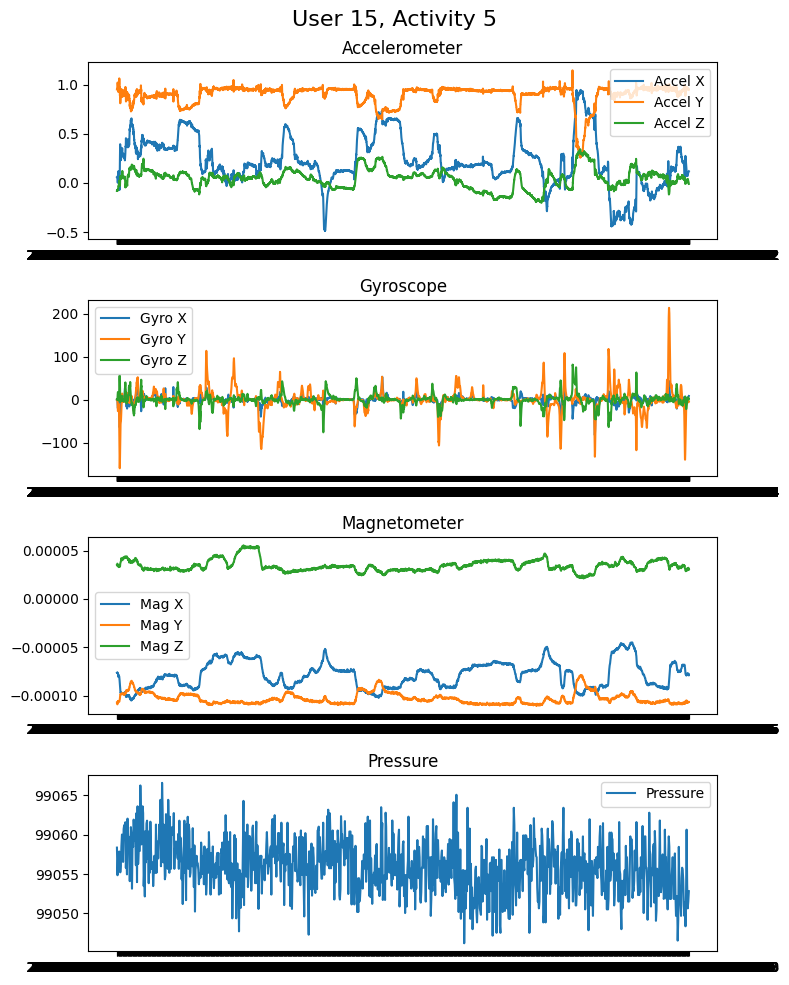

In [ ]:
user_id   = 15
activity_id = 5

plot_one_user_one_activity(user_id, activity_id)

## 5. Classification

1. **Train/Test Split:** Split the extracted feature data into **train** and **test** sets.
2. **Classification:** Using multiple ML classifiers like LogisticRegression, NaiveBayes, DecisionTree, RandomForest.
3. **Ensemble:** OAn ensemble (`VotingClassifier`) of the best models.

Metrics for each Classifiers (Accuracy, Precision, Recall, F1 Score).

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    unique_labels = np.unique(y_test)
    if len(unique_labels) == 2 and hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
        auc_val = roc_auc_score(y_test, y_score)
        print(f"AUC:       {auc_val:.4f}")
    elif len(unique_labels) == 2:
        print("Model has no predict_proba; cannot compute AUC.")

In [ ]:
all_classifiers = {
    "LogisticRegression": (
        LogisticRegression(solver='liblinear', max_iter=1200),
        {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l1", "l2"]
        }
    ),
    "NaiveBayes": (
        GaussianNB(),
        {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=45),
        {
            "max_depth": [None, 5, 10, 20],
            "min_samples_leaf": [1, 2, 5]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [50, 100],
            "max_depth": [None, 10, 20],
            "min_samples_leaf": [1, 2]
        }
    )
}

df = all_features_df.copy().fillna(0)
y = df["activity_id"].astype(str)
X = df.drop(columns=["activity_id", "user_id"], errors="ignore").select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("[INFO] Train shape:", X_train.shape, "& Test shape:", X_test.shape)

chosen_classifiers = all_classifiers

best_models = {}
best_scores = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name, (clf_template, param_dict) in chosen_classifiers.items():
    print(f"\n=== Tuning {clf_name} ===")
    param_list = list(ParameterGrid(param_dict))
    total_candidates = len(param_list)

    best_score = -1.0
    best_params = None
    best_model_obj = None

    for idx, params in enumerate(param_list):
        print(f"\n--> (Candidate {idx+1}/{total_candidates}) => {params}")
        model_temp = clf_template.set_params(**params)
        fold_scores = []
        for fold_i, (train_idxF, val_idxF) in enumerate(cv.split(X_train, y_train)):
            X_trF = X_train.iloc[train_idxF]
            X_valF = X_train.iloc[val_idxF]
            y_trF = y_train.iloc[train_idxF]
            y_valF = y_train.iloc[val_idxF]

            model_temp.fit(X_trF, y_trF)
            acc_fold = model_temp.score(X_valF, y_valF)
            print(f"    [fold {fold_i+1}/{cv.n_splits}] => accuracy={acc_fold:.4f}")
            fold_scores.append(acc_fold)

        mean_cv = np.mean(fold_scores)
        print(f"    => Candidate mean CV score={mean_cv:.4f}")
        if mean_cv > best_score:
            best_score = mean_cv
            best_params = params
            best_model_obj = clf_template.set_params(**params)

    best_model_obj.fit(X_train, y_train)
    print(f"\n[INFO] Best params for {clf_name}: {best_params}")
    print(f"[INFO] Best CV score for {clf_name}: {best_score:.4f}")

    print(f"\n--- Final Test Evaluation: {clf_name} ---")
    evaluate_model(best_model_obj, X_test, y_test)

    best_models[clf_name] = best_model_obj
    best_scores[clf_name] = best_score

importances = None
final_model = None

print("\n[INFO] Combining best models into a VotingClassifier.")
from sklearn.ensemble import VotingClassifier
estimators = [(n, m) for n, m in best_models.items()]
final_model = VotingClassifier(estimators=estimators, voting='soft')
final_model.fit(X_train, y_train)
print("\n--- Final Test Evaluation: Ensemble ---")
evaluate_model(final_model, X_test, y_test)

best_model = final_model

[INFO] Train shape: (1499, 50) & Test shape: (500, 50)

=== Tuning LogisticRegression ===

--> (Candidate 1/8) => {'C': 0.01, 'penalty': 'l1'}
    [fold 1/5] => accuracy=0.2000
    [fold 2/5] => accuracy=0.2400
    [fold 3/5] => accuracy=0.2367
    [fold 4/5] => accuracy=0.2267
    [fold 5/5] => accuracy=0.2174
    => Candidate mean CV score=0.2241

--> (Candidate 2/8) => {'C': 0.01, 'penalty': 'l2'}
    [fold 1/5] => accuracy=0.2267
    [fold 2/5] => accuracy=0.2200
    [fold 3/5] => accuracy=0.2433
    [fold 4/5] => accuracy=0.2233
    [fold 5/5] => accuracy=0.2207
    => Candidate mean CV score=0.2268

--> (Candidate 3/8) => {'C': 0.1, 'penalty': 'l1'}
    [fold 1/5] => accuracy=0.2667
    [fold 2/5] => accuracy=0.2800
    [fold 3/5] => accuracy=0.2567
    [fold 4/5] => accuracy=0.2367
    [fold 5/5] => accuracy=0.2508
    => Candidate mean CV score=0.2582

--> (Candidate 4/8) => {'C': 0.1, 'penalty': 'l2'}
    [fold 1/5] => accuracy=0.2233
    [fold 2/5] => accuracy=0.2167
    [fol

## 6. Single Activity Prediction

After classification, demonstrates an activity prediction on a single user's single activity.

prediction_user = 16  
prediction_activity = 4   

- Loads the 4 sensor CSVs for that user/activity.
- Windows them, extracts the same features.

All 15 activity lables with details.

In [ ]:
ACTIVITY_LABELS = {
    1:  "Sitting - Reading a book",
    2:  "Sitting - Writing in a notebook",
    3:  "Using computer - Typing",
    4:  "Using computer - Browsing",
    5:  "While sitting - Moving head, body",
    6:  "While sitting - Moving chair",
    7:  "Sitting - Stand up from sitting",
    8:  "Standing",
    9:  "Walking",
    10: "Running",
    11: "Taking stairs",
    12: "Sitting - Stationary, Wear it, Put it back, Stationary",
    13: "Standing Stationary, Wear it, Put it back, Stationary",
    14: "Sitting - Pick up items from floor",
    15: "Standing - Pick up items from floor"
}

print("\nActivity Labels:")
for act_id, act_name in sorted(ACTIVITY_LABELS.items()):
    print(f"  Activity {act_id} => {act_name}")


Activity Labels:
  Activity 1 => Sitting - Reading a book
  Activity 2 => Sitting - Writing in a notebook
  Activity 3 => Using computer - Typing
  Activity 4 => Using computer - Browsing
  Activity 5 => While sitting - Moving head, body
  Activity 6 => While sitting - Moving chair
  Activity 7 => Sitting - Stand up from sitting
  Activity 8 => Standing
  Activity 9 => Walking
  Activity 10 => Running
  Activity 11 => Taking stairs
  Activity 12 => Sitting - Stationary, Wear it, Put it back, Stationary
  Activity 13 => Standing Stationary, Wear it, Put it back, Stationary
  Activity 14 => Sitting - Pick up items from floor
  Activity 15 => Standing - Pick up items from floor


Prediction using single activity.

In [ ]:
def predict_activity_for_single_activity(user_id, activity_id, trained_model):
    print(f"\n[INFO] Predicting activity for User {user_id}, Activity {activity_id}...\n")

    activity_dir = os.path.join(DATASET_PATH, f"User{user_id}", f"Activity{activity_id}")
    acc_file   = os.path.join(activity_dir, "Accelerometer.csv")
    gyro_file  = os.path.join(activity_dir, "Gyroscope.csv")
    mag_file   = os.path.join(activity_dir, "Magnetometer.csv")
    press_file = os.path.join(activity_dir, "Pressure.csv")

    acc_df   = load_sensor_data(acc_file)
    gyro_df  = load_sensor_data(gyro_file)
    mag_df   = load_sensor_data(mag_file)
    press_df = load_sensor_data(press_file)

    acc_w   = window_data(acc_df, WINDOW_SIZE)
    gyro_w  = window_data(gyro_df, WINDOW_SIZE)
    mag_w   = window_data(mag_df, WINDOW_SIZE)
    press_w = window_data(press_df, WINDOW_SIZE)

    n_w = min(len(acc_w), len(gyro_w), len(mag_w), len(press_w))
    if n_w == 0:
        print("[WARNING] No complete windows => can't predict.")
        return None

    all_feats = []
    for i in range(n_w):
        feats = {}
        feats.update(extract_features("accelerometer", acc_w[i]))
        feats.update(extract_features("gyroscope",     gyro_w[i]))
        feats.update(extract_features("magnetometer",  mag_w[i]))
        feats.update(extract_features("pressure",      press_w[i]))
        all_feats.append(feats)

    df_features = pd.DataFrame(all_feats).fillna(0)
    y_pred = trained_model.predict(df_features)
    majority_label = pd.Series(y_pred).value_counts().idxmax()
    print(f"[PREDICTION] Majority predicted class = {majority_label}")

    try:
        label_int = int(majority_label)
        if label_int in ACTIVITY_LABELS:
            print(f"[PREDICTION] This corresponds to: {ACTIVITY_LABELS[label_int]}")
    except ValueError:
        pass

Pass the prediction_user and prediction_activity to get the predicted class and corresponding lable.

In [ ]:
prediction_user = 22
prediction_activity = 9

predict_activity_for_single_activity(prediction_user, prediction_activity, best_model)


[INFO] Predicting activity for User 22, Activity 9...

[PREDICTION] Majority predicted class = 9
[PREDICTION] This corresponds to: Walking


In [ ]:
prediction_user = 17
prediction_activity = 2

predict_activity_for_single_activity(prediction_user, prediction_activity, best_model)


[INFO] Predicting activity for User 17, Activity 2...

[PREDICTION] Majority predicted class = 2
[PREDICTION] This corresponds to: Sitting - Writing in a notebook


In [ ]:
prediction_user = 27
prediction_activity = 12

predict_activity_for_single_activity(prediction_user, prediction_activity, best_model)


[INFO] Predicting activity for User 27, Activity 12...

[PREDICTION] Majority predicted class = 12
[PREDICTION] This corresponds to: Sitting - Stationary, Wear it, Put it back, Stationary


In [ ]:
prediction_user = 19
prediction_activity = 7

predict_activity_for_single_activity(prediction_user, prediction_activity, best_model)


[INFO] Predicting activity for User 19, Activity 7...

[PREDICTION] Majority predicted class = 7
[PREDICTION] This corresponds to: Sitting - Stand up from sitting


In [ ]:
prediction_user = 14
prediction_activity = 4

predict_activity_for_single_activity(prediction_user, prediction_activity, best_model)


[INFO] Predicting activity for User 14, Activity 4...

[PREDICTION] Majority predicted class = 4
[PREDICTION] This corresponds to: Using computer - Browsing
